<a href="https://colab.research.google.com/github/a9e68ce5/Machine-Learning/blob/main/CNN%20for%20Face%20Expression%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Import packages***

In [ ]:
import os
import random
import glob
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


In [ ]:
!gdown 1drrS7gnyzUJPPiQcDWcHdIXqzjy2n3yZ
!unzip 'HW2.zip'

串流輸出內容已截斷至最後 5000 行。
 extracting: data/train/35561.jpg    
 extracting: data/train/25855.jpg    
 extracting: data/train/19327.jpg    
 extracting: data/train/26948.jpg    
 extracting: data/train/11690.jpg    
 extracting: data/train/16673.jpg    
 extracting: data/train/11974.jpg    
 extracting: data/train/29951.jpg    
 extracting: data/train/19225.jpg    
 extracting: data/train/16735.jpg    
 extracting: data/train/29258.jpg    
 extracting: data/train/34324.jpg    
 extracting: data/train/23429.jpg    
 extracting: data/train/32778.jpg    
 extracting: data/train/18948.jpg    
 extracting: data/train/16266.jpg    
 extracting: data/train/32922.jpg    
 extracting: data/train/19090.jpg    
 extracting: data/train/11971.jpg    
 extracting: data/train/32888.jpg    
 extracting: data/train/23236.jpg    
 extracting: data/train/10155.jpg    
 extracting: data/train/26199.jpg    
 extracting: data/train/28311.jpg    
 extracting: data/train/18732.jpg    
 extracting: data/train/12197

# ***Set arguments and random seed***

In [ ]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'
DEVICE_ID = 0
SEED = 5566
NUM_ECPOCH = 50

torch.cuda.set_device(DEVICE_ID)
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ***Process data***

In [ ]:
def load_train_data(img_path, label_path, valid_ratio=0.12):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'{img_path}/{i+10000}.jpg' for i in range(len(train_label)-1)]

    train_data = list(zip(train_image, train_label))
    random.shuffle(train_data)

    split_len = int(len(train_data) * valid_ratio)
    train_set = train_data[split_len:]
    valid_set = train_data[:split_len]

    return train_set, valid_set

def load_test_data(img_path):
    test_set = [f'{img_path}/{i}.jpg' for i in range(7000, 10000)]
    return test_set

def compute_statistics(dataset):
    data = []
    for (img_path, label) in dataset:
        data.append(np.array(Image.open(img_path)))
    data = np.array(data)
    return data.mean(), data.std()

In [ ]:
train_set, valid_set = load_train_data(TRA_PATH, LABEL_PATH)
test_set = load_test_data(TST_PATH)
size=(64,64)
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.RandomCrop(64,padding=2),#以圖片(PIL Image)中隨機裁減一塊圖像出來
                 transforms.ToPILImage(mode=None)]   #轉成tensor之後一定要轉回PIL才可以讀
                 )

# ***train set中各類表情的數量***

In [ ]:
unzip=zip(*train_set)
c=list(unzip)
c=c[1]
c={"label":c}
c=pd.DataFrame(c)
c['label'].value_counts()

3    5762
6    3925
4    3785
2    3296
0    3139
5    2515
1     358
Name: label, dtype: int64

# ***Customize dataset***

In [ ]:
class FaceExpressionDataset(Dataset):
    def __init__(self, data, augment=None):
        self.data = data
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def normalize(self, data):
        data=data/255
        return data
    def read_img(self, idx):
        img = Image.open(self.data[idx][0])
        if not self.augment is None:
            img = self.augment(img)
        img = torch.from_numpy(np.array(img)).float()
        img = img.unsqueeze(0).float()
        img = self.normalize(img)
        return img

    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.data[idx][1]
        return img, label

class TestingDataset(Dataset):
    def __init__(self, data, augment=None):
        self.data = data
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def normalize(self, data):
       data=data/255
       return data

    def read_img(self, idx):
        img = Image.open(self.data[idx])
        if not self.augment is None:
            img = self.augment(img)
        img = torch.from_numpy(np.array(img)).float()
        img = img.unsqueeze(0).float()
        img = self.normalize(img)
        return img, self.data[idx].split('/')[-1][:-4]

    def __getitem__(self, idx):
        img, name = self.read_img(idx)

        return img, name

In [ ]:
train_dataset = FaceExpressionDataset(train_set, transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = FaceExpressionDataset(valid_set)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = TestingDataset(test_set)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ***Define module class***

In [ ]:
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super(FaceExpressionNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),


            nn.Conv2d(32,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),


            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),




            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.05),

            nn.MaxPool2d((2,2)),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 32 * 32,128),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Linear(128,128),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Linear(128,7),

        )

    def forward(self, x):
        #image size (64,64)
        x = self.conv(x) #(32,32)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x


# ***Define training and testing process***

In [ ]:
def train(train_loader, model, loss_fn, use_gpu=True):
    model.train()
    train_loss = []
    train_acc = []
    train_result=[]
    for (img, label) in train_loader:
        if use_gpu:
            img = img.to(device)
            label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        with torch.no_grad():#停止对梯度的计算和存储 ，从而减少对内存的消耗，不会进行反向传播。
            predict = torch.argmax(output, dim=-1)#輸出每一行的最大值
            predict2=predict.tolist()
            train_result+=predict2
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
            predict=predict.flatten()
    train_acc = np.mean(train_acc)
    print("Epoch: {}, train Loss: {:.4f}, train Acc: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
    return train_acc
def valid(valid_loader, model, loss_fn, use_gpu=True):
    model.eval()
    with torch.no_grad():#停止对梯度的计算和存储 ，从而减少对内存的消耗，不会进行反向传播。
        valid_loss = []
        valid_acc = []
        for idx, (img, label) in enumerate(valid_loader):
            if use_gpu:
                img = img.to(device)
                label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            predict = torch.argmax(output, dim=-1)
            acc = (label == predict).cpu().tolist()
            valid_loss.append(loss.item())
            valid_acc += acc

        valid_acc = np.mean(valid_acc)
        valid_loss = np.mean(valid_loss)
        print("Epoch: {}, valid Loss: {:.4f}, valid Acc: {:.4f}".format(epoch + 1, valid_loss, valid_acc))#{:.4f}:輸出到小數點後四位
    return valid_acc

def save_checkpoint(valid_acc, acc_record, epoch, prefix='model'):
    # you can define the condition to save model :)
    if valid_acc >= np.mean(acc_record[-5:]):
        checkpoint_path = f'{prefix}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print('model saved to %s' % checkpoint_path)
    return valid_acc
def better(acc_record):
    if max(acc_record) == acc_record[-1]: return True
    return False

# ***實作Early Stopping***

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True #表示暱名函式（ Anonymous Function ）。
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):#判斷是否是空值
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

# ***Training***

Epoch: 1, train Loss: 2.9801, train Acc: 0.2735
Epoch: 1, valid Loss: 1.6539, valid Acc: 0.3529
model saved to model.pth
########################################################
Epoch: 2, train Loss: 1.5707, train Acc: 0.3896
Epoch: 2, valid Loss: 1.6374, valid Acc: 0.3860
model saved to model.pth
########################################################
Epoch: 3, train Loss: 1.4647, train Acc: 0.4337
Epoch: 3, valid Loss: 1.3962, valid Acc: 0.4630
model saved to model.pth
########################################################
Epoch: 4, train Loss: 1.3977, train Acc: 0.4619
Epoch: 4, valid Loss: 1.4260, valid Acc: 0.4527
########################################################
Epoch: 5, train Loss: 1.3473, train Acc: 0.4820
Epoch: 5, valid Loss: 1.3411, valid Acc: 0.4871
model saved to model.pth
########################################################
Epoch: 6, train Loss: 1.3225, train Acc: 0.4914
Epoch: 6, valid Loss: 1.3125, valid Acc: 0.4845
#######################################

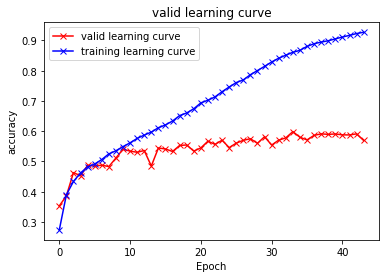

In [ ]:
es = EarlyStopping(patience = 10)
if __name__ == '__main__':
    model = FaceExpressionNet()
    if use_gpu:
        model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    acc_record = []
    train_acc = []

    for epoch in range(NUM_ECPOCH):
        result=train(train_loader, model, loss_fn, use_gpu)
        train_acc.append(result)
        valid_acc = valid(valid_loader, model, loss_fn, use_gpu=True)
        acc_record.append(valid_acc)
        if better(acc_record):
            best_acc=save_checkpoint(valid_acc, acc_record, epoch, prefix='model')
        if es.step(valid_acc):
          print("Early stopping with best_acc: {:.4f} at Epoch: {}". format(best_acc,epoch+1))
          break
        print('########################################################')
    #predict=np.array(result)
    #unzip=zip(*train_set)
    #a=list(unzip)
    #a=a[1]
    #b=np.array(a)
    #crosstab=pd.crosstab(np.array(b),np.array(predict),rownames=['Actual'],colnames=['Predicted'])
    #print(crosstab)




%matplotlib inline
fig = plt.figure() #定義一個圖像窗口
plt.title("valid learning curve")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
line1,=plt.plot(acc_record, '-x',color='red',label='valid learning curve') #定義x,y和圖的樣式
line2,=plt.plot(train_acc, '-x',color='blue',label='training learning curve') #定義x,y和圖的樣式
plt.legend(handles = [line1, line2])




In [ ]:
def test(test_loader, model, file_name='predict.csv'):
    with torch.no_grad():
        predict_result = []
        predict_name = []
        for img, name in test_loader:
            if use_gpu:
                img = img.to(device)
            output = model(img)
            predict = torch.argmax(output, dim=-1).tolist()
            predict_result += predict
            predict_name += name
    with open(file_name, 'w', newline='') as csvfile:#寫入csv檔案
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in zip(predict_name, predict_result):
            writer.writerow([id, r])

# ***Testing***

In [ ]:
del model
model = FaceExpressionNet()
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
test(test_loader, model)